# Fix

In [1]:
import pandas as pd
from pathlib import Path
import re

def extract_constraint_level_from_filename(filename):
    """
    Extract constraint level from filename
    Example: 'eval_claude_3_haiku_50_with_goldprob.csv' -> '50'
    """
    match = re.search(r'_(\d+)_with_goldprob\.csv$', filename)
    if match:
        return match.group(1)
    # Check for baseline (0)
    if '_0_with_goldprob.csv' in filename or filename.endswith('_with_goldprob.csv'):
        return '0'
    return None

def load_and_organize_results(base_dir, language):
    """
    Load results organized by model and constraint level
    
    Args:
        base_dir: Base directory containing results
        language: 'en' or 'fa'
    
    Returns:
        Dictionary with organized data by question
    """
    lang_dir = f"{language}_with_goldprob"
    results_path = Path(base_dir) / lang_dir
    
    # Dictionary to store data: {question_index: {model: {level: data}}}
    organized_data = {}
    
    model_dirs = [d for d in results_path.iterdir() if d.is_dir()]
    print(f"\nProcessing {language.upper()} data from {len(model_dirs)} models")
    
    for model_dir in model_dirs:
        model_name = model_dir.name
        csv_files = list(model_dir.glob("*_with_goldprob.csv"))
        
        print(f"\n  Model: {model_name} ({len(csv_files)} files)")
        
        for csv_file in csv_files:
            constraint_level = extract_constraint_level_from_filename(csv_file.name)
            
            if constraint_level is None:
                print(f"    ⚠ Skipping {csv_file.name} - couldn't extract level")
                continue
            
            try:
                df = pd.read_csv(csv_file)
                print(f"    ✓ Level {constraint_level}: {len(df)} questions")
                
                # Organize by question index
                for _, row in df.iterrows():
                    q_idx = row['index']
                    
                    if q_idx not in organized_data:
                        organized_data[q_idx] = {}
                    if model_name not in organized_data[q_idx]:
                        organized_data[q_idx][model_name] = {}
                    
                    organized_data[q_idx][model_name][constraint_level] = {
                        'is_correct_noexp': row['is_correct_noexp'],
                        'is_correct_exp': row['is_correct_exp'],
                        'gold_prob_noexp': row['gold_prob_noexp'],
                        'gold_prob_exp': row['gold_prob_exp'],
                        'delta_gold_prob': row['delta_gold_prob'],
                        'question': row['question'],
                        'gold': row['gold']
                    }
                    
            except Exception as e:
                print(f"    ✗ Error loading {csv_file.name}: {e}")
    
    return organized_data

def create_statistical_datasets(organized_data, output_dir, language):
    """
    Create McNemar and t-test datasets from organized data
    """
    output_path = Path(output_dir) / language
    output_path.mkdir(parents=True, exist_ok=True)
    
    mcnemar_rows = []
    ttest_rows = []
    
    print(f"\nCreating datasets for {len(organized_data)} questions...")
    
    for q_idx, models_data in organized_data.items():
        for model_name, levels_data in models_data.items():
            # Get baseline (level 0)
            if '0' not in levels_data:
                continue
            
            baseline = levels_data['0']
            
            # Create row with baseline
            mcnemar_row = {
                'question_id': q_idx,
                'model': model_name,
                'question': baseline['question'],
                'gold': baseline['gold'],
                'is_correct_noexp': baseline['is_correct_noexp'],
                'is_correct_exp_z0': baseline['is_correct_exp']
            }
            
            ttest_row = {
                'question_id': q_idx,
                'model': model_name,
                'question': baseline['question'],
                'gold': baseline['gold'],
                'gold_prob_noexp': baseline['gold_prob_noexp'],
                'gold_prob_exp_z0': baseline['gold_prob_exp']
            }
            
            # Add all constraint levels
            for level in sorted(levels_data.keys(), key=lambda x: int(x)):
                if level == '0':
                    continue
                
                data = levels_data[level]
                mcnemar_row[f'is_correct_exp_z{level}'] = data['is_correct_exp']
                ttest_row[f'gold_prob_exp_z{level}'] = data['gold_prob_exp']
                
                # Calculate delta from baseline
                ttest_row[f'delta_z0_to_z{level}'] = (
                    baseline['gold_prob_exp'] - data['gold_prob_exp']
                )
            
            mcnemar_rows.append(mcnemar_row)
            ttest_rows.append(ttest_row)
    
    # Create DataFrames
    mcnemar_df = pd.DataFrame(mcnemar_rows)
    ttest_df = pd.DataFrame(ttest_rows)
    
    # Save to CSV
    mcnemar_file = output_path / "mcnemar_data.csv"
    ttest_file = output_path / "ttest_data.csv"
    
    mcnemar_df.to_csv(mcnemar_file, index=False)
    ttest_df.to_csv(ttest_file, index=False)
    
    print(f"\n✓ Saved McNemar data: {mcnemar_file}")
    print(f"  Shape: {mcnemar_df.shape}")
    print(f"  Columns: {mcnemar_df.columns.tolist()}")
    
    print(f"\n✓ Saved t-test data: {ttest_file}")
    print(f"  Shape: {ttest_df.shape}")
    print(f"  Columns: {ttest_df.columns.tolist()}")
    
    # Show sample
    print("\n📊 Sample McNemar data:")
    print(mcnemar_df.head(3))
    
    print("\n📊 Sample t-test data:")
    print(ttest_df.head(3))
    
    # Identify constraint levels
    constraint_levels = sorted([
        col.replace('is_correct_exp_z', '') 
        for col in mcnemar_df.columns 
        if col.startswith('is_correct_exp_z')
    ], key=lambda x: int(x))
    
    print(f"\n🎯 Detected constraint levels: {constraint_levels}")
    
    return mcnemar_df, ttest_df, constraint_levels

# Main execution
if __name__ == "__main__":
    base_directory = "../models/evaluation/qwen_1.7B"
    output_directory = "statistical_analysis"
    
    print("=" * 70)
    print("EXTRACTING STATISTICAL DATA")
    print("=" * 70)
    
    # Process English
    print("\n" + "=" * 70)
    print("ENGLISH DATA")
    print("=" * 70)
    en_organized = load_and_organize_results(base_directory, 'en')
    en_mcnemar, en_ttest, en_levels = create_statistical_datasets(
        en_organized, output_directory, 'en'
    )
    
    # Process Persian
    print("\n" + "=" * 70)
    print("PERSIAN DATA")
    print("=" * 70)
    fa_organized = load_and_organize_results(base_directory, 'fa')
    fa_mcnemar, fa_ttest, fa_levels = create_statistical_datasets(
        fa_organized, output_directory, 'fa'
    )
    
    print("\n" + "=" * 70)
    print("EXTRACTION COMPLETE")
    print("=" * 70)
    print(f"\nEnglish: {len(en_mcnemar)} samples, Levels: {en_levels}")
    print(f"Persian: {len(fa_mcnemar)} samples, Levels: {fa_levels}")
    print(f"\nModels in English: {en_mcnemar['model'].unique().tolist()}")
    print(f"Models in Persian: {fa_mcnemar['model'].unique().tolist()}")

EXTRACTING STATISTICAL DATA

ENGLISH DATA


FileNotFoundError: [Errno 2] No such file or directory: '../models/evaluation/qwen_1.7B/en_with_goldprob'

## Visualization

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar
from pathlib import Path

def perform_mcnemar_tests(data, constraint_levels):
    """
    Perform McNemar's test comparing baseline (z0) with each constraint level
    
    Args:
        data: DataFrame with columns is_correct_exp_z0, is_correct_exp_z10, etc.
        constraint_levels: List of constraint levels (e.g., ['0', '10', '20', ...])
    
    Returns:
        DataFrame with test results
    """
    results = []
    
    baseline_col = 'is_correct_exp_z0'
    
    for level in constraint_levels:
        if level == '0':
            continue
            
        constraint_col = f'is_correct_exp_z{level}'
        
        if constraint_col not in data.columns:
            print(f"Warning: {constraint_col} not found in data")
            continue
        
        # Create contingency table
        # McNemar table: [[both_correct, baseline_correct_only],
        #                 [constraint_correct_only, both_incorrect]]
        both_correct = ((data[baseline_col] == True) & (data[constraint_col] == True)).sum()
        baseline_only = ((data[baseline_col] == True) & (data[constraint_col] == False)).sum()
        constraint_only = ((data[baseline_col] == False) & (data[constraint_col] == True)).sum()
        both_incorrect = ((data[baseline_col] == False) & (data[constraint_col] == False)).sum()
        
        table = [[both_correct, baseline_only],
                 [constraint_only, both_incorrect]]
        
        # Perform McNemar's test
        try:
            result = mcnemar(table, exact=False, correction=True)
            
            results.append({
                'test': f'McNemar: Z0 vs Z{level}',
                'level': level,
                'statistic': result.statistic,
                'pvalue': result.pvalue,
                'both_correct': both_correct,
                'baseline_only': baseline_only,
                'constraint_only': constraint_only,
                'both_incorrect': both_incorrect,
                'n': len(data),
                'significant_005': result.pvalue < 0.05,
                'significant_001': result.pvalue < 0.01
            })
        except Exception as e:
            print(f"Error in McNemar test for Z0 vs Z{level}: {e}")
    
    return pd.DataFrame(results)


def perform_paired_ttests(data, constraint_levels):
    """
    Perform paired t-tests comparing baseline probabilities with each constraint level
    
    Args:
        data: DataFrame with columns gold_prob_exp_z0, gold_prob_exp_z10, etc.
        constraint_levels: List of constraint levels
    
    Returns:
        DataFrame with test results
    """
    results = []
    
    baseline_col = 'gold_prob_exp_z0'
    
    for level in constraint_levels:
        if level == '0':
            continue
            
        constraint_col = f'gold_prob_exp_z{level}'
        
        if constraint_col not in data.columns:
            print(f"Warning: {constraint_col} not found in data")
            continue
        
        # Remove NaN values
        valid_mask = data[baseline_col].notna() & data[constraint_col].notna()
        baseline_probs = data.loc[valid_mask, baseline_col]
        constraint_probs = data.loc[valid_mask, constraint_col]
        
        if len(baseline_probs) == 0:
            print(f"Warning: No valid data for Z0 vs Z{level}")
            continue
        
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(baseline_probs, constraint_probs)
        
        # Calculate effect size (Cohen's d for paired samples)
        differences = baseline_probs - constraint_probs
        mean_diff = differences.mean()
        std_diff = differences.std()
        cohens_d = mean_diff / std_diff if std_diff > 0 else 0
        
        # Calculate confidence interval for mean difference
        ci = stats.t.interval(0.95, len(differences)-1, 
                             loc=mean_diff, 
                             scale=stats.sem(differences))
        
        results.append({
            'test': f't-test: Z0 vs Z{level}',
            'level': level,
            'statistic': t_stat,
            'pvalue': p_value,
            'mean_diff': mean_diff,
            'std_diff': std_diff,
            'cohens_d': cohens_d,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'n': len(baseline_probs),
            'significant_005': p_value < 0.05,
            'significant_001': p_value < 0.01
        })
    
    return pd.DataFrame(results)


def analyze_language(language, analysis_dir='statistical_analysis'):
    """
    Run complete statistical analysis for a language
    
    Args:
        language: 'en' or 'fa'
        analysis_dir: Directory containing the data files
    
    Returns:
        Tuple of (mcnemar_results, ttest_results)
    """
    lang_path = Path(analysis_dir) / language
    
    # Load data
    mcnemar_data = pd.read_csv(lang_path / 'mcnemar_data.csv')
    ttest_data = pd.read_csv(lang_path / 'ttest_data.csv')
    
    print(f"\n{'='*70}")
    print(f"STATISTICAL ANALYSIS - {language.upper()}")
    print(f"{'='*70}")
    
    # Detect constraint levels
    constraint_levels = sorted([
        col.replace('is_correct_exp_z', '') 
        for col in mcnemar_data.columns 
        if col.startswith('is_correct_exp_z')
    ], key=lambda x: int(x))
    
    print(f"Constraint levels: {constraint_levels}")
    print(f"Total samples: {len(mcnemar_data)}")
    
    # McNemar's Tests
    print(f"\n{'='*70}")
    print("MCNEMAR'S TESTS (Accuracy Changes)")
    print(f"{'='*70}")
    
    mcnemar_results = perform_mcnemar_tests(mcnemar_data, constraint_levels)
    
    if not mcnemar_results.empty:
        print(f"\nPerformed {len(mcnemar_results)} McNemar tests")
        print(f"Significant at α=0.05: {mcnemar_results['significant_005'].sum()}")
        print(f"Significant at α=0.01: {mcnemar_results['significant_001'].sum()}")
        
        # Save results
        mcnemar_file = lang_path / 'mcnemar_results.csv'
        mcnemar_results.to_csv(mcnemar_file, index=False)
        print(f"\n✓ Saved: {mcnemar_file}")
    
    # Paired t-tests
    print(f"\n{'='*70}")
    print("PAIRED T-TESTS (Probability Changes)")
    print(f"{'='*70}")
    
    ttest_results = perform_paired_ttests(ttest_data, constraint_levels)
    
    if not ttest_results.empty:
        print(f"\nPerformed {len(ttest_results)} paired t-tests")
        print(f"Significant at α=0.05: {ttest_results['significant_005'].sum()}")
        print(f"Significant at α=0.01: {ttest_results['significant_001'].sum()}")
        
        # Print effect sizes
        print("\nEffect Sizes (Cohen's d):")
        for _, row in ttest_results.iterrows():
            effect = "negligible" if abs(row['cohens_d']) < 0.2 else \
                     "small" if abs(row['cohens_d']) < 0.5 else \
                     "medium" if abs(row['cohens_d']) < 0.8 else "large"
            print(f"  {row['test']}: d={row['cohens_d']:.3f} ({effect})")
        
        # Save results
        ttest_file = lang_path / 'ttest_results.csv'
        ttest_results.to_csv(ttest_file, index=False)
        print(f"\n✓ Saved: {ttest_file}")
    
    return mcnemar_results, ttest_results


# Run analysis for both languages
print("=" * 70)
print("RUNNING STATISTICAL TESTS")
print("=" * 70)

# English
en_mcnemar_results, en_ttest_results = analyze_language('en')

# Persian
fa_mcnemar_results, fa_ttest_results = analyze_language('fa')

print("\n" + "=" * 70)
print("COMPLETE!")
print("=" * 70)
print("\nResults saved to statistical_analysis/*/")
print("  • mcnemar_results.csv")
print("  • ttest_results.csv")

RUNNING STATISTICAL TESTS

STATISTICAL ANALYSIS - EN
Constraint levels: ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']
Total samples: 20647

MCNEMAR'S TESTS (Accuracy Changes)

Performed 9 McNemar tests
Significant at α=0.05: 9
Significant at α=0.01: 9

✓ Saved: statistical_analysis/en/mcnemar_results.csv

PAIRED T-TESTS (Probability Changes)

Performed 9 paired t-tests
Significant at α=0.05: 9
Significant at α=0.01: 9

Effect Sizes (Cohen's d):
  t-test: Z0 vs Z10: d=0.340 (small)
  t-test: Z0 vs Z20: d=0.269 (small)
  t-test: Z0 vs Z30: d=0.225 (small)
  t-test: Z0 vs Z40: d=0.186 (negligible)
  t-test: Z0 vs Z50: d=0.160 (negligible)
  t-test: Z0 vs Z60: d=0.139 (negligible)
  t-test: Z0 vs Z70: d=0.113 (negligible)
  t-test: Z0 vs Z80: d=0.097 (negligible)
  t-test: Z0 vs Z90: d=0.079 (negligible)

✓ Saved: statistical_analysis/en/ttest_results.csv

STATISTICAL ANALYSIS - FA
Constraint levels: ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90']
Total samples: 2

## Visualization

CREATING VISUALIZATIONS AND REPORTS

--- ENGLISH ---

✓ Visualization saved to statistical_analysis/en/statistical_visualization_en.png


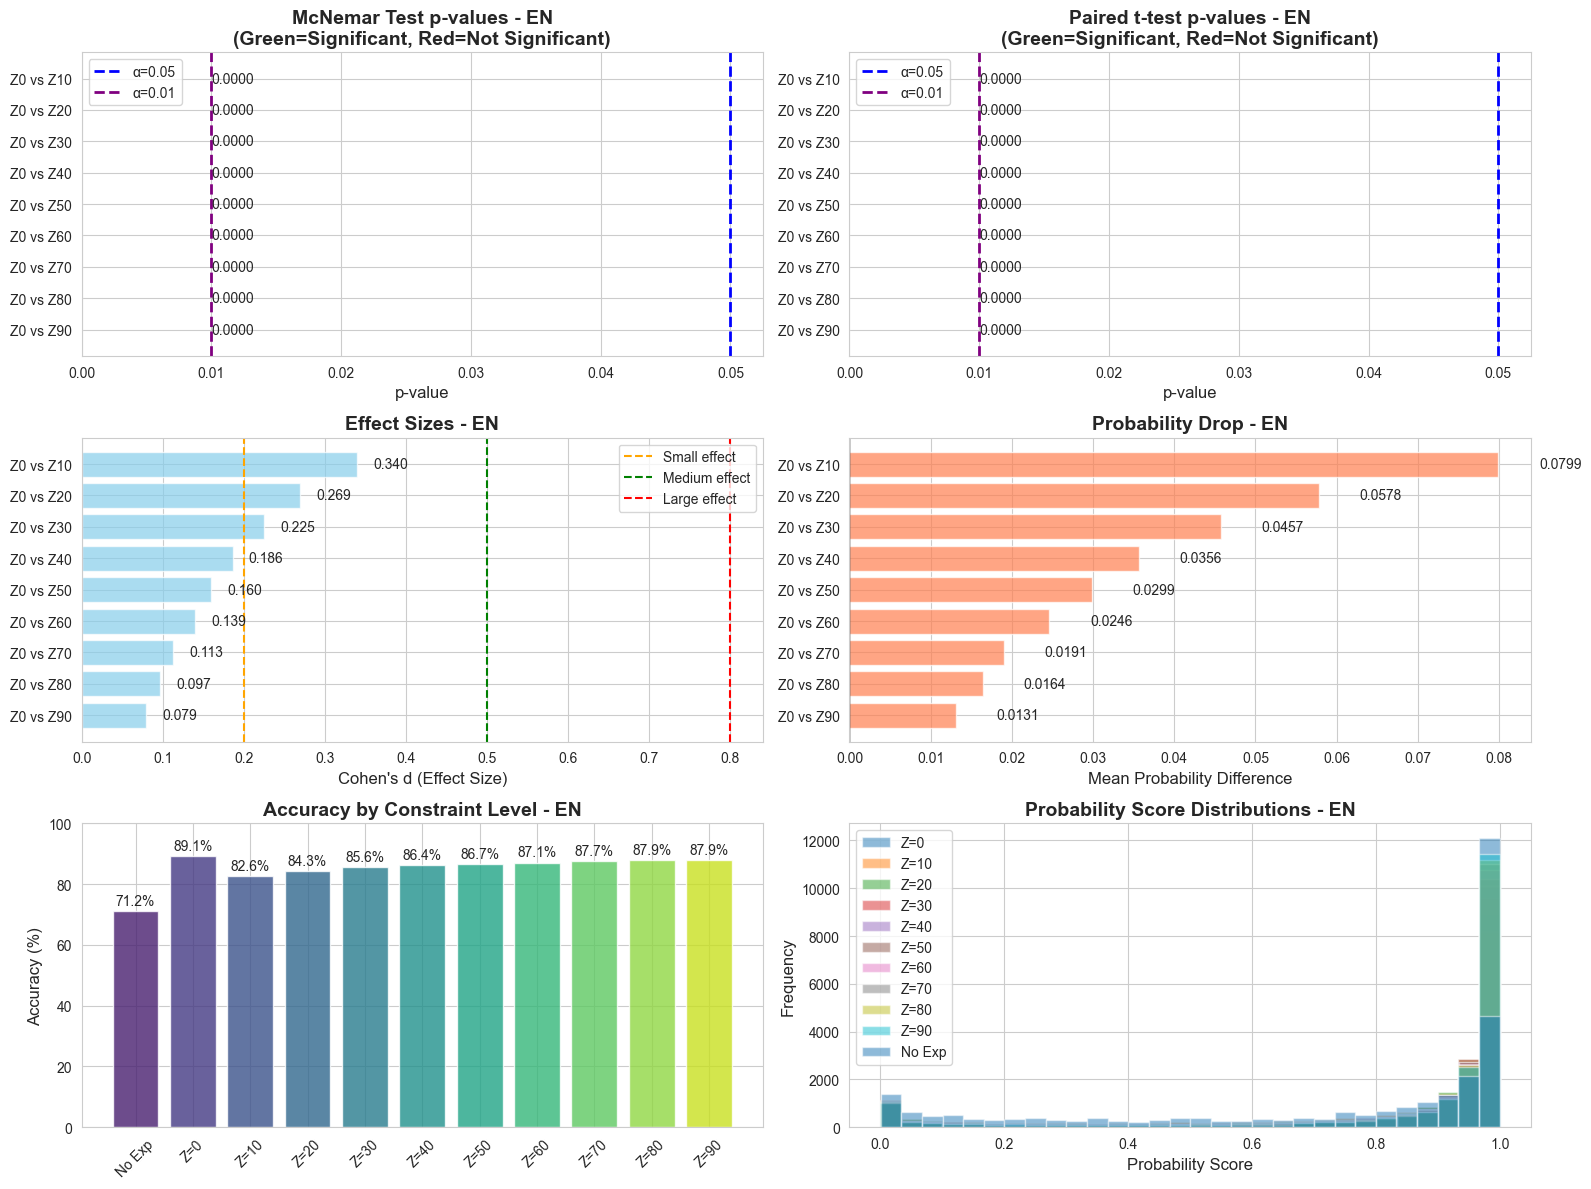

STATISTICAL ANALYSIS SUMMARY - EN

--- McNemar's Test Results (Accuracy Changes) ---

Significant tests (α=0.05): 9/9

McNemar: Z0 vs Z10
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z20
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z30
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z40
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z50
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z60
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z70
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z80
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

McNemar: Z0 vs Z90
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20647

--------------------------------------------------------------------------------
--- Paired t-test Results (Probability Changes) ---

Significant tests (α=0.05): 9/9

t-test: Z0 vs Z10
  p

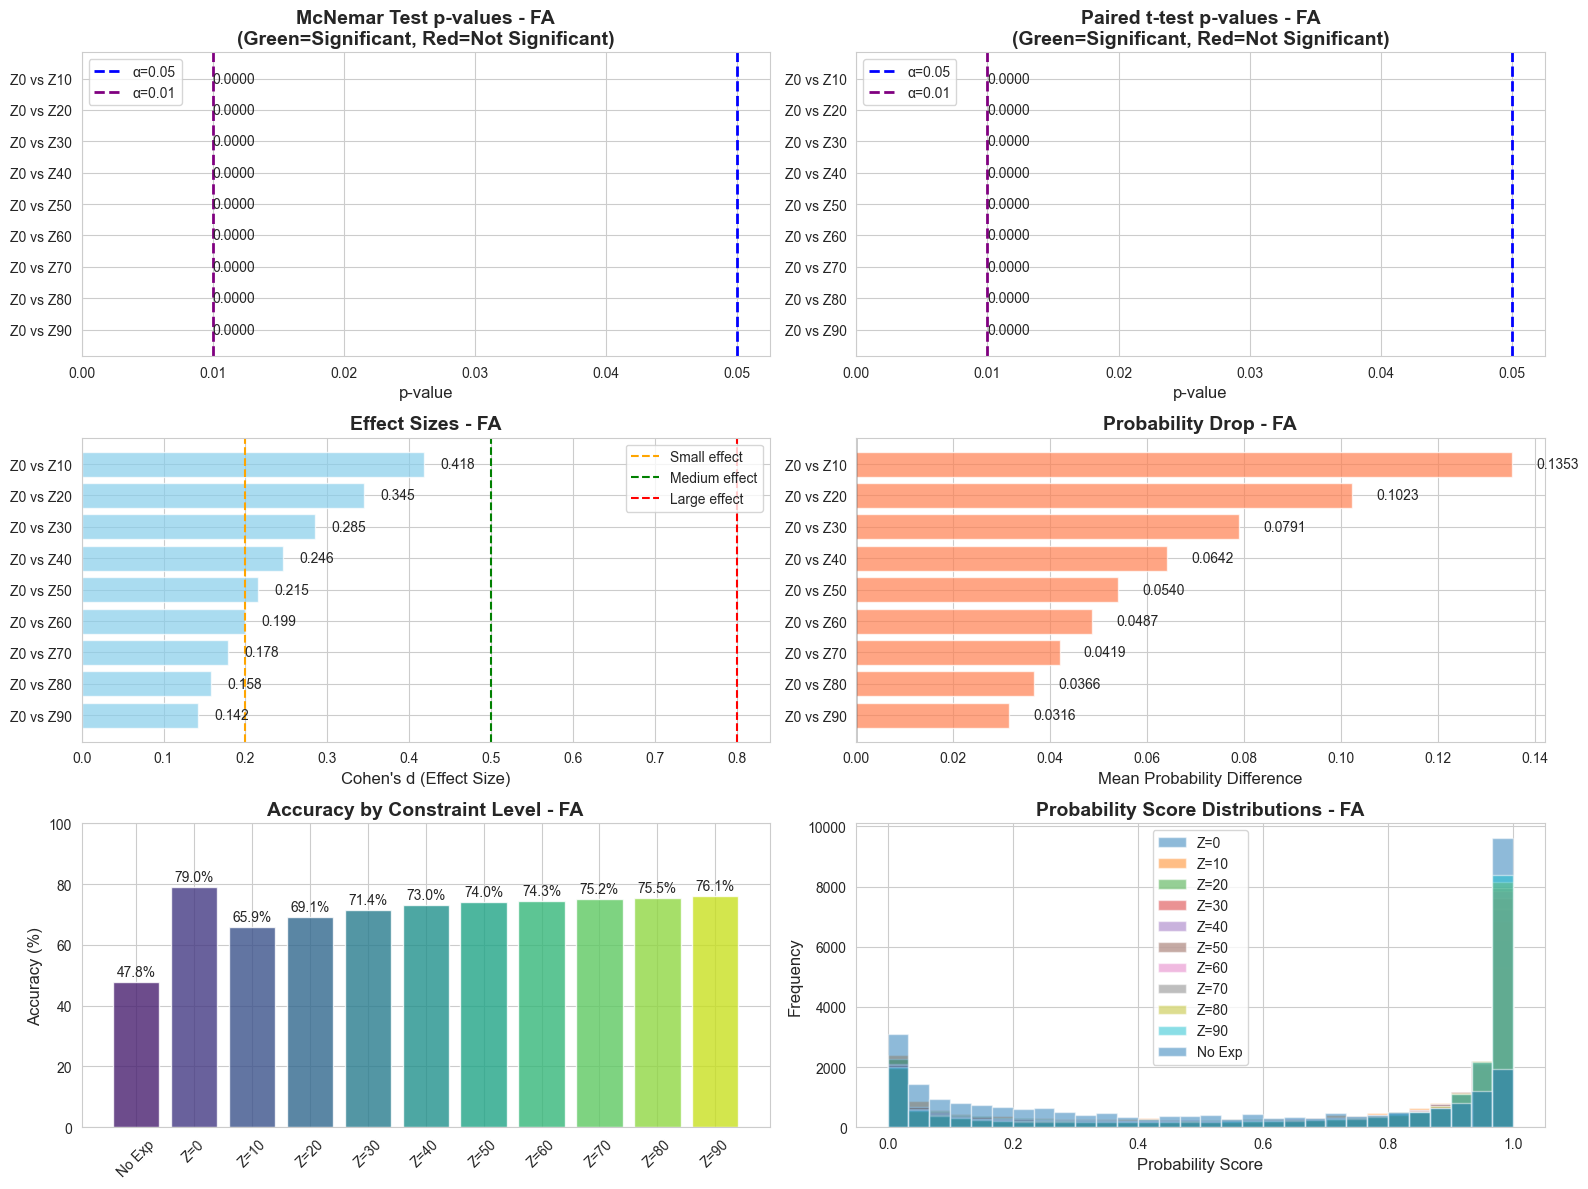

STATISTICAL ANALYSIS SUMMARY - FA

--- McNemar's Test Results (Accuracy Changes) ---

Significant tests (α=0.05): 9/9

McNemar: Z0 vs Z10
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z20
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z30
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z40
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z50
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z60
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z70
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z80
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

McNemar: Z0 vs Z90
  p-value: 0.000000 - ✓ SIGNIFICANT
  Sample size: 20648

--------------------------------------------------------------------------------
--- Paired t-test Results (Probability Changes) ---

Significant tests (α=0.05): 9/9

t-test: Z0 vs Z10
  p

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def visualize_statistical_results(language, analysis_dir="statistical_analysis"):
    """
    Create visualizations for statistical test results
    
    Args:
        language: 'en' or 'fa'
        analysis_dir: Directory containing the analysis results
    """
    lang_path = Path(analysis_dir) / language
    
    # Load the results files
    mcnemar_results = pd.read_csv(lang_path / "mcnemar_results.csv")
    ttest_results = pd.read_csv(lang_path / "ttest_results.csv")
    mcnemar_data = pd.read_csv(lang_path / "mcnemar_data.csv")
    ttest_data = pd.read_csv(lang_path / "ttest_data.csv")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # ========== 1. McNemar p-values (Accuracy) ==========
    ax1 = plt.subplot(3, 2, 1)
    mcnemar_plot = mcnemar_results.copy()
    mcnemar_plot['test_short'] = mcnemar_plot['test'].str.replace('McNemar: ', '')
    
    colors = ['green' if p < 0.05 else 'red' for p in mcnemar_plot['pvalue']]
    bars = ax1.barh(mcnemar_plot['test_short'], mcnemar_plot['pvalue'], color=colors, alpha=0.7)
    ax1.axvline(x=0.05, color='blue', linestyle='--', linewidth=2, label='α=0.05')
    ax1.axvline(x=0.01, color='purple', linestyle='--', linewidth=2, label='α=0.01')
    ax1.set_xlabel('p-value', fontsize=12)
    ax1.set_title(f'McNemar Test p-values - {language.upper()}\n(Green=Significant, Red=Not Significant)', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.invert_yaxis()
    
    # Add p-value labels
    for i, (p, bar) in enumerate(zip(mcnemar_plot['pvalue'], bars)):
        ax1.text(p + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{p:.4f}', va='center', fontsize=10)
    
    # ========== 2. t-test p-values (Sufficiency) ==========
    ax2 = plt.subplot(3, 2, 2)
    ttest_plot = ttest_results.copy()
    ttest_plot['test_short'] = ttest_plot['test'].str.replace('t-test: ', '')
    
    colors = ['green' if p < 0.05 else 'red' for p in ttest_plot['pvalue']]
    bars = ax2.barh(ttest_plot['test_short'], ttest_plot['pvalue'], color=colors, alpha=0.7)
    ax2.axvline(x=0.05, color='blue', linestyle='--', linewidth=2, label='α=0.05')
    ax2.axvline(x=0.01, color='purple', linestyle='--', linewidth=2, label='α=0.01')
    ax2.set_xlabel('p-value', fontsize=12)
    ax2.set_title(f'Paired t-test p-values - {language.upper()}\n(Green=Significant, Red=Not Significant)', 
                  fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.invert_yaxis()
    
    # Add p-value labels
    for i, (p, bar) in enumerate(zip(ttest_plot['pvalue'], bars)):
        ax2.text(p + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{p:.4f}', va='center', fontsize=10)
    
    # ========== 3. Effect Sizes (Cohen's d) ==========
    ax3 = plt.subplot(3, 2, 3)
    bars = ax3.barh(ttest_plot['test_short'], ttest_plot['cohens_d'], 
                    color='skyblue', alpha=0.7)
    ax3.axvline(x=0.2, color='orange', linestyle='--', label='Small effect')
    ax3.axvline(x=0.5, color='green', linestyle='--', label='Medium effect')
    ax3.axvline(x=0.8, color='red', linestyle='--', label='Large effect')
    ax3.set_xlabel("Cohen's d (Effect Size)", fontsize=12)
    ax3.set_title(f"Effect Sizes - {language.upper()}", fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.invert_yaxis()
    
    # Add labels
    for d, bar in zip(ttest_plot['cohens_d'], bars):
        ax3.text(d + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{d:.3f}', va='center', fontsize=10)
    
    # ========== 4. Mean Probability Differences ==========
    ax4 = plt.subplot(3, 2, 4)
    bars = ax4.barh(ttest_plot['test_short'], ttest_plot['mean_diff'], 
                    color='coral', alpha=0.7)
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax4.set_xlabel('Mean Probability Difference', fontsize=12)
    ax4.set_title(f'Probability Drop - {language.upper()}', fontsize=14, fontweight='bold')
    ax4.invert_yaxis()
    
    # Add labels
    for d, bar in zip(ttest_plot['mean_diff'], bars):
        ax4.text(d + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{d:.4f}', va='center', fontsize=10)
    
    # ========== 5. Accuracy Comparison (Stacked Bar) ==========
    ax5 = plt.subplot(3, 2, 5)
    
    # Get constraint levels
    constraint_cols = [col for col in mcnemar_data.columns if 'is_correct_exp_z' in col]
    
    accuracies = []
    labels = []
    
    if 'is_correct_noexp' in mcnemar_data.columns:
        accuracies.append(mcnemar_data['is_correct_noexp'].mean() * 100)
        labels.append('No Exp')
    
    for col in sorted(constraint_cols):
        level = col.split('_z')[-1]
        accuracies.append(mcnemar_data[col].mean() * 100)
        labels.append(f'Z={level}')
    
    bars = ax5.bar(labels, accuracies, color=sns.color_palette("viridis", len(accuracies)), alpha=0.8)
    ax5.set_ylabel('Accuracy (%)', fontsize=12)
    ax5.set_title(f'Accuracy by Constraint Level - {language.upper()}', 
                  fontsize=14, fontweight='bold')
    ax5.set_ylim([0, 100])
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45)
    
    # ========== 6. Probability Distribution Comparison ==========
    ax6 = plt.subplot(3, 2, 6)
    
    prob_cols = [col for col in ttest_data.columns if 'gold_prob' in col and 'delta' not in col]
    
    for col in sorted(prob_cols):
        if col == 'question_id' or col == 'model':
            continue
        label = col.replace('gold_prob_', '').replace('noexp', 'No Exp').replace('exp_z', 'Z=')
        ax6.hist(ttest_data[col].dropna(), bins=30, alpha=0.5, label=label)
    
    ax6.set_xlabel('Probability Score', fontsize=12)
    ax6.set_ylabel('Frequency', fontsize=12)
    ax6.set_title(f'Probability Score Distributions - {language.upper()}', 
                  fontsize=14, fontweight='bold')
    ax6.legend()
    
    plt.tight_layout()
    
    # Save figure
    output_file = lang_path / f"statistical_visualization_{language}.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved to {output_file}")
    
    plt.show()
    
    return fig


def create_summary_report(language, analysis_dir="statistical_analysis"):
    """
    Create a text summary report of the statistical analysis
    """
    lang_path = Path(analysis_dir) / language
    
    mcnemar_results = pd.read_csv(lang_path / "mcnemar_results.csv")
    ttest_results = pd.read_csv(lang_path / "ttest_results.csv")
    
    report = []
    report.append("=" * 80)
    report.append(f"STATISTICAL ANALYSIS SUMMARY - {language.upper()}")
    report.append("=" * 80)
    report.append("")
    
    # McNemar Tests Summary
    report.append("--- McNemar's Test Results (Accuracy Changes) ---")
    report.append("")
    significant_count = mcnemar_results['significant_005'].sum()
    total_tests = len(mcnemar_results)
    report.append(f"Significant tests (α=0.05): {significant_count}/{total_tests}")
    report.append("")
    
    for _, row in mcnemar_results.iterrows():
        sig_marker = "✓ SIGNIFICANT" if row['significant_005'] else "✗ NOT SIGNIFICANT"
        report.append(f"{row['test']}")
        report.append(f"  p-value: {row['pvalue']:.6f} - {sig_marker}")
        report.append(f"  Sample size: {row['n']}")
        report.append("")
    
    # t-test Summary
    report.append("-" * 80)
    report.append("--- Paired t-test Results (Probability Changes) ---")
    report.append("")
    significant_count = ttest_results['significant_005'].sum()
    total_tests = len(ttest_results)
    report.append(f"Significant tests (α=0.05): {significant_count}/{total_tests}")
    report.append("")
    
    for _, row in ttest_results.iterrows():
        sig_marker = "✓ SIGNIFICANT" if row['significant_005'] else "✗ NOT SIGNIFICANT"
        
        # Interpret effect size
        cohen_d = abs(row['cohens_d'])
        if cohen_d < 0.2:
            effect = "negligible"
        elif cohen_d < 0.5:
            effect = "small"
        elif cohen_d < 0.8:
            effect = "medium"
        else:
            effect = "large"
        
        report.append(f"{row['test']}")
        report.append(f"  p-value: {row['pvalue']:.6f} - {sig_marker}")
        report.append(f"  Mean difference: {row['mean_diff']:.4f}")
        report.append(f"  Cohen's d: {row['cohens_d']:.4f} ({effect} effect)")
        report.append(f"  Sample size: {row['n']}")
        report.append("")
    
    report.append("=" * 80)
    report.append("INTERPRETATION GUIDE:")
    report.append("  • p-value < 0.05: Statistically significant")
    report.append("  • p-value < 0.01: Highly significant")
    report.append("  • Cohen's d: |d| < 0.2 (small), 0.2-0.5 (medium), > 0.8 (large)")
    report.append("=" * 80)
    
    # Save report
    report_text = "\n".join(report)
    report_file = lang_path / f"summary_report_{language}.txt"
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    print(report_text)
    print(f"\n✓ Report saved to {report_file}")
    
    return report_text


# Run visualizations for both languages
print("=" * 70)
print("CREATING VISUALIZATIONS AND REPORTS")
print("=" * 70)

# English
print("\n--- ENGLISH ---")
en_fig = visualize_statistical_results('en')
en_report = create_summary_report('en')

# Persian
print("\n--- PERSIAN ---")
fa_fig = visualize_statistical_results('fa')
fa_report = create_summary_report('fa')

print("\n" + "=" * 70)
print("COMPLETE! Check the statistical_analysis/ folder for:")
print("  • Visualizations (.png files)")
print("  • Summary reports (.txt files)")
print("  • Raw results (.csv files)")
print("=" * 70)